# Assigment 3 Deep Learning
### by Yeramian Kevin

In [1]:
# Import for the Assigment3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import pickle
import copy as copy
from numpy import random
from tqdm import tqdm

# Exercice 1
## update Assigment 2 to K-layers

In [2]:
# Global Variable
training_file = "data_batch_1"
validation_file = "data_batch_2"
test_file = "test_batch"
data_folder = "../save/assigment1-save/Datasets/cifar-10-batches-py/"
N = 10000
K = 10
d = 3072
m = 50


In [3]:
# Trasnform a vector of label to a vector of hot-one(dumies)
def hot_one(y):
    Y = []
    for yi in y:
        yihot = [0] * K
        yihot[yi] = 1
        Y.append(yihot)
    return np.array(Y)
    
    
#Functions that load data from file.
def load_batch(file_name):

    with open(file_name, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    y = np.hstack(dict[b'labels'])
    X = dict[b'data'].astype(float).T / 255.0
    Y = hot_one(y).T
    return X,Y,y

#Function that normalize the data( Only mean)
#Input : - X(d,N)
#Output: - X(d,N)

def normalizeData(X):
    m = np.mean(X,1)
    X = (X.T - m).T
    return X, m


#Output:
# A list of weight and biais

def initializeWb(dim_list):
    mu = 0
    sigma = 0.01
    W = []
    b = []
    for i in range(len(dim_list) - 1):
        W.append(np.random.normal(mu, sigma, (dim_list[i + 1], dim_list[i])))
        b.append(np.random.normal(mu, sigma, (dim_list[i + 1], 1)))
    return W, b

#Output : # P (KxN)
def evaluate_Classifier(X,W,b):
    X_i = []
    h = X
    X_i.append(copy.deepcopy(h))
    
    for i in range(0,len(W) - 1):
        s1 = np.dot(W[i],h) + b[i]
        h = np.maximum(s1, 0)
        X_i.append(copy.deepcopy(h))
    s = np.dot(W[-1],h) + b[-1]
    
    aux = np.exp(s)
    summ = np.sum(aux, axis=0) #axis=0 sum by colum so we got 1000 therm to normalize
    p = aux / summ
    return p, X_i

def compute_Cost(X, Y, W, b, lamb):
    J = 0.0
    p, _ = evaluate_Classifier(X, W, b) # K * N
    for index in range(X.shape[1]):
        J += -np.log(np.dot(p[:,index], Y[:,index]))
    J /= X.shape[1]
    for w in W:
        J += lamb * np.sum(np.square(w))
    return J

def compute_Accuracy(X, y, W, b):
    p, _ = evaluate_Classifier(X, W, b) # P ( K×N)
    pred = np.argmax(p,axis=0)
    acc = 0.0
    for i in range(len(pred)):
        if(pred[i] == y[i]):
            acc += 1
    return acc /len(pred)




def compute_Gradients(X, Y, p, X_i, W, b, lamb):
    grad_W = []
    grad_b = []
    N = X.shape[1]
    # Initialization of grad
    for i in range(len(W)):
        grad_W.append(np.zeros((W[i].shape[0],W[i].shape[1])))
        grad_b.append(np.zeros((b[i].shape[0],b[i].shape[1])))
    
    #case k 
    
    g = - (Y.T - p.T).T
    gx = np.dot(g,X_i[-1].T)
    grad_b[-1] += np.mean(g, axis=-1, keepdims=True)
    
    grad_W[-1] += gx
    grad_W[-1] /= N
    grad_W[-1] += 2 * lamb * W[-1]
    
    #First update of g
    
    g = np.dot(g.T,W[-1])
    g1 = np.where(X_i[-1] > 0, 1, 0) ### TODO CHECK IF PROBLEM
    g = np.multiply(g.T, g1)
    
    for l in range(len(W) - 2, -1, -1):
        grad_b[l] += np.mean(g, axis=-1, keepdims=True)
        gx = np.dot(g,X_i[l].T)
        grad_W[l] += gx
        grad_W[l] /= N
        grad_W[l] += 2 * lamb * W[l]
        
        g = np.dot(g.T,W[l])
        g1 = np.where(X_i[l] > 0, 1, 0) ### TODO CHECK IF PROBLEM
        g = np.multiply(g.T, g1)
        
    return grad_W, grad_b


def compute_Gradients_Num(X, Y, P, W, b, lamb, h):
    grad_W = []
    grad_b = []
    N = X.shape[1]
    # Initialization of grad
    for i in range(len(W)):
        grad_W.append(np.zeros((W[i].shape[0],W[i].shape[1])))
        grad_b.append(np.zeros((b[i].shape[0],b[i].shape[1])))
        
    c =  compute_Cost(X, Y, W, b, lamb)
    
    for index in range(len(W)):
        for i in range(W[index].shape[0]):
            for j in range(W[index].shape[1]):
                W[index][i][j] += h
                c2 = compute_Cost(X, Y, W, b, lamb)
                grad_W[index][i][j] = (c2 - c) / h
                W[index][i][j] -= h

        for i in range(len(b[index])):
            b[index][i] += h
            c2 = compute_Cost(X, Y, W, b, lamb)
            grad_b[index][i] = (c2 - c) / h
            b[index][i] -= h
                
   
    return np.array(grad_W), np.array(grad_b)

## Load Data

In [4]:
#Load of every datasete
X_train, Y_train, y_train = load_batch(data_folder + training_file)
X_test, Y_test, y_test = load_batch(data_folder + test_file)
X_val, Y_val, y_val = load_batch(data_folder + validation_file)


X_train, m = normalizeData(X_train)
X_test = (X_test.T - m).T
X_val = (X_val.T - m).T

## Test  of K-layer

In [11]:
# Test Initialization
d =13
dim_list = [d, 20, 20, 10,K]
h = 1e-6
lamb = 0
W,b = initializeWb(dim_list)

X = X_train[:d,:12]
Y = Y_train[:,:12]
y = y_train[:12]

print("Size check")
print(len(W),len(b))
print("Shape check")
print((W[0].shape))

#Test Evaluation

print("Test evaluation")
p, X_i = evaluate_Classifier(X,W, b)
print(p[:,0])

# Test Compute_Cost
print("Test Cost")
print(compute_Cost(X, Y, W, b,1))

# Test Accuracy
print("Test Accuracy")
acc = compute_Accuracy(X, y, W, b)
print(acc)

# Test grad
print("Test grad")


p, X_i = evaluate_Classifier(X,W,b)

grad_W1, grad_b1 = compute_Gradients(X, Y, p, X_i, W, b, lamb)
grad_W11, grad_b11  = compute_Gradients_Num(X, Y, p, W, b, lamb, h)


for i in range(len(W)):
    print("Norm for W & b for the " + str(i) + "layer")
    print(np.linalg.norm(grad_W1[i] - grad_W11[i],ord=1) / max(h ,np.linalg.norm(grad_W1[i] ,ord=1) + np.linalg.norm(grad_W11[i] ,ord=1)))
    print(np.linalg.norm(grad_b1[i] - grad_b11[i],ord=1) / max(h ,np.linalg.norm(grad_b1[i] ,ord=1) + np.linalg.norm(grad_b11[i] ,ord=1)))

Size check
4 4
Shape check
(20, 13)
Test evaluation
[0.09904616 0.09936909 0.09890528 0.10057174 0.10001712 0.0997647
 0.10063742 0.10101619 0.1011745  0.09949781]
Test Cost
2.4009447199844907
Test Accuracy
0.08333333333333333
Test grad
Norm for W & b for the 0layer
0.0009851342117999146
0.0002017407296632636
Norm for W & b for the 1layer
0.00034345388613922127
8.083079429863071e-06
Norm for W & b for the 2layer
1.026133426536774e-05
2.0180374191262224e-07
Norm for W & b for the 3layer
4.208723563475326e-07
4.2491761199606007e-07


## Train  K - Layers

In [12]:
def fit(X, Y, y, X_val, Y_val, y_val, lamb, n_batch, rho, eta , n_epochs, dim_list, W, b):
    d = X.shape[0]
    N = X.shape[1]
    
    
    lostTrain = []
    lostVal = []
    W_momentum = []
    b_momentum = []
    for i in range(len(W)):
        W_momentum.append(np.zeros((W[i].shape[0],W[i].shape[1])))
        b_momentum.append(np.zeros((b[i].shape[0],b[i].shape[1])))
    
    
    for _ in range(n_epochs):
        for j in range(int(N / n_batch)):
            start = j * n_batch
            end = (j + 1) * n_batch
            X_batch = X[:,start:end]
            Y_batch = Y[:,start:end]
            p, X_i = evaluate_Classifier(X_batch, W, b)
            grad_W, grad_b = compute_Gradients(X_batch, Y_batch, p, X_i, W, b, lamb)

            for i in range(len(W)):
                W_momentum[i] = W_momentum[i] * rho +  eta * grad_W[i]
                b_momentum[i] = b_momentum[i] * rho +  eta * grad_b[i]
                W[i] -= W_momentum[i]
                b[i] -= b_momentum[i]
        
        #print("Accurency on the test = "  + str(compute_Accuracy(X_val, y_val, W1, b1, W2, b2)))
        eta *= 0.95
        lostTrain.append(compute_Cost(X, Y, W, b, lamb))
        lostVal.append(compute_Cost(X_val, Y_val, W, b, lamb))
    
    return W, b, lostTrain, lostVal

# Exercice 2
## K-layer

## Test Exercice 1 - 2 for 2-layers (50)

In [15]:

N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 0.0001

dim_list = [d, 50, K]
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]

n_batch= 100
eta= 0.01
n_epochs= 50
rho = 0.9
W, b, lostTrain, lostVal = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list)

print("Accurency on the test = "  + str(compute_Accuracy(X_test, y_test, W, b)))

Accurency on the test = 0.4501


## Plot curve

In [13]:
def plot_curve(lostTrain, lostVal):
    rr = range(len(lostVal))
    plt.plot(rr, lostVal,'green')
    plt.plot(rr, lostTrain,'blue')
    plt.title("loss during the training for eta = " + str(eta) + " lambda = " + str(lamb))
    green_patch = mpatches.Patch(color='blue', label="Training loss")
    blue_patch = mpatches.Patch(color='green', label="Validation loss")
    plt.legend(handles=[green_patch, blue_patch])
    plt.savefig(str(lamb) + '_'+ str(eta) + '.png')
    plt.show()

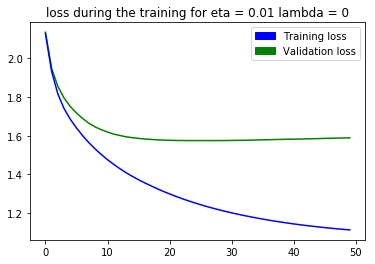

In [26]:
plot_curve(lostTrain, lostVal)

## Test with 3-layers (50, 30)

Accurency on the test = 0.4137


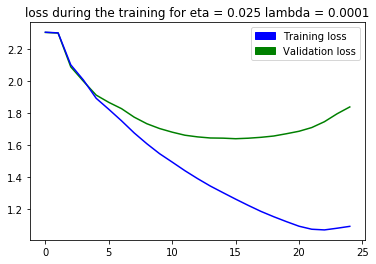

In [42]:
N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 0.0001

dim_list = [d, 50, 30, K]
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]


n_batch= 100
eta= 0.025
n_epochs= 25
rho = 0.9
W_init, b_init = initializeWb(dim_list)

W, b, lostTrain, lostVal = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init)

print("Accurency on the test = "  + str(compute_Accuracy(X_test, y_test, W, b)))
plot_curve(lostTrain, lostVal)

## Hu initialization

In [14]:
def initializeWb_He(dim_list):
    mu = 0
    W = []
    b = []
    for i in range(len(dim_list) - 1):
        W.append(np.random.normal(mu, np.sqrt(2.0 / dim_list[i + 1]), (dim_list[i + 1], dim_list[i])))
        b.append(np.random.normal(mu, np.sqrt(2.0 / dim_list[i + 1]), (dim_list[i + 1], 1)))
    return W, b



In [7]:
N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 0.0001

dim_list = [d, 50, 30, K]
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]


n_batch= 100
eta= 0.01
n_epochs= 5
rho = 0.9
W_init, b_init = initializeWb_He(dim_list)

W, b, lostTrain, lostVal = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init)

print("Accurency on the test = "  + str(compute_Accuracy(X_test, y_test, W, b)))
plot_curve(lostTrain, lostVal)

NameError: name 'fit' is not defined

# Exercie 3
## Batch Normalization
### First version with normalization from batch

## Gradient check

In [76]:
def batch_norm(sl, mul, nul, eps):
    assert(len(nul) == len(mul))
    sl = sl.T
    for i in range(len(sl)):
        assert(len(sl[i]) == len(mul))
        for j in range(len(sl[i])):
            sl[i][j] = (sl[i][j] - mul[j]) /  ((nul[j] + eps) ** 0.5)
    return  sl.T

def evaluate_Classifier_batch(X,W,b, eps, mean_layer=None, std_layer=None):
    X_i = []
    X_i_hat = []
    h = X
    X_i.append(copy.deepcopy(h))
    X_i_hat.append(copy.deepcopy(h))  
    
    mean_layer_out = []
    std_layer_out = []
    for i in range(0,len(W) - 1):
        s1 = np.dot(W[i], h) + b[i]
        s_norm = [0]
        X_i.append(copy.deepcopy(s1))
        if(mean_layer == None):
            
            mul = np.mean(s1, 1)
            nul = np.std(s1, 1)
            mean_layer_out.append(mul)
            std_layer_out.append(nul)
            s_norm = batch_norm(s1, mul, nul, eps)
        else:
            s_norm = batch_norm(s1, mean_layer[i], std_layer[i], eps)
        h = np.maximum(s_norm, 0)
        X_i_hat.append(copy.deepcopy(h))
    
    s = np.dot(W[-1],h) + b[-1]
    aux = np.exp(s)
    summ = np.sum(aux, axis=0) #axis=0 sum by colum so we got 1000 therm to normalize
    p = aux / summ
    return p, X_i, X_i_hat, mean_layer_out, std_layer_out

def compute_Accuracy_batch(X, y, W, b, eps, mean_layer, std_layer):
    p, _, _, _ = evaluate_Classifier_batch(X, W, b, eps, mean_layer, std_layer) 
    pred = np.argmax(p,axis=0)
    acc = 0.0
    for i in range(len(pred)):
        if(pred[i] == y[i]):
            acc += 1
    return acc /len(pred)

def compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer):
    J = 0.0
    
    
    p, _, _, _, _ = evaluate_Classifier_batch(X, W, b, eps, mean_layer, std_layer)
    #print(p.T[0])
    for index in range(X.shape[1]):
        J += -np.log(np.dot(p[:,index], Y[:,index]))
    J /= X.shape[1]
    for w in W:
        J += lamb * np.sum(np.square(w))
    return J

def compute_Gradients_Num_batch(X, Y, P, W, b, lamb, h, eps, mean_layer, std_layer):
    grad_W = []
    grad_b = []
    N = X.shape[1]
    # Initialization of grad
    for i in range(len(W)):
        grad_W.append(np.zeros((W[i].shape[0],W[i].shape[1])))
        grad_b.append(np.zeros((b[i].shape[0],b[i].shape[1])))
        
    c =  compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer)
    
    for index in range(len(W)):
        for i in range(W[index].shape[0]):
            for j in range(W[index].shape[1]):
                W[index][i][j] += h
                c2 = compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer)
                grad_W[index][i][j] = (c2 - c) / h
                W[index][i][j] -= h

        for i in range(len(b[index])):
            b[index][i] += h
            c2 = compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer)
            grad_b[index][i] = (c2 - c) / h
            b[index][i] -= h
                
   
    return np.array(grad_W), np.array(grad_b)

In [114]:
def compute_Gradients_batch(X, Y, p, X_i, X_i_hat, W, b, lamb, mean_layer, std_layer):
    grad_W = []
    grad_b = []
    N = X.shape[1]
    # Initialization of grad
    for i in range(len(W)):
        grad_W.append(np.zeros((W[i].shape[0],W[i].shape[1])))
        grad_b.append(np.zeros((b[i].shape[0],b[i].shape[1])))
        
    #case k 
 
    g = - (Y.T - p.T).T
 
    gx = np.dot(g,X_i_hat[-1].T)
    grad_b[-1] += np.mean(g, axis=-1, keepdims=True)
    
    grad_W[-1] += gx
    grad_W[-1] /= N
    grad_W[-1] += 2 * lamb * W[-1]
    
    #First update of g
    
    g = np.dot(g.T,W[-1])
    g1 = np.where(X_i_hat[-1] > 0, 1, 0) ### TODO CHECK IF PROBLEM
    g = np.multiply(g.T, g1)
    
   
    for l in range(len(W) - 2, -1, -1):
        
        g = g.T
        #print(mean_layer[l].shape)
        X_i_centered = np.subtract(X_i[l + 1].T, mean_layer[l])
        
        gradJ_std = - (std_layer[l] ** (-1.5)) * np.sum(g * X_i_centered, axis=0, keepdims=True)
        print(np.sum(g * X_i_centered, axis=0, keepdims=True).shape)
        print(gradJ_std.shape)
        gradJ_mean = - (std_layer[l] ** (-0.5)) * np.sum(g, axis=0, keepdims=True)
        print(gradJ_mean.shape)
        g =  g * (std_layer[l] ** (-0.5)) + gradJ_std *  X_i_centered / N#
        g += (gradJ_mean / N)
        g = g.T
        
        grad_b[l] += np.mean(g, axis=1, keepdims=True)
        gx = np.dot(g,X_i_hat[l].T)
        grad_W[l] += gx
        grad_W[l] /= N
        grad_W[l] += 2 * lamb * W[l]
        
        g = np.dot(g.T,W[l])
        g1 = np.where(X_i_hat[l] > 0, 1, 0) ### TODO CHECK IF PROBLEM
        g = np.multiply(g.T, g1)
        
    return grad_W, grad_b

## Test on the gradient 

In [115]:
K = 10
d = 30
dim_list = [d, 20,K]
h = 10e-6
lamb = 0
rho = 0.9

eps = 10e-06

X = X_train[:d,:12]
Y = Y_train[:,:12]
#W_init, b_init = initializeWb_He(dim_list)

p, X_i, X_i_hat, mean_layer, std_layer = evaluate_Classifier_batch(X, W_init, b_init , eps)

grad_W1, grad_b1 = compute_Gradients_batch(X, Y, p, X_i, X_i_hat, W_init, b_init, lamb, mean_layer, std_layer)

grad_W11, grad_b11  = compute_Gradients_Num_batch(X, Y, p, W_init, b_init, lamb, h, eps, mean_layer, std_layer)


for i in range(len(W_init)):
    print("Norm for W & b for the " + str(i) + "layer")
    assert(grad_W1[i].shape == grad_W11[i].shape)
    assert(grad_b1[i].shape == grad_b11[i].shape)
    print(np.linalg.norm(grad_W1[i] - grad_W11[i],ord=1) / max(h ,np.linalg.norm(grad_W1[i] ,ord=1) + np.linalg.norm(grad_W11[i] ,ord=1)))
    print(np.linalg.norm(grad_b1[i] - grad_b11[i],ord=1) / max(h ,np.linalg.norm(grad_b1[i] ,ord=1) + np.linalg.norm(grad_b11[i] ,ord=1)))

(1, 20)
(1, 20)
(1, 20)
Norm for W & b for the 0layer
0.2170356793350981
0.9999999999999999
Norm for W & b for the 1layer
1.7986831202519667e-06
2.5990883387193013e-06


In [92]:
def fit(X, Y, y, X_val, Y_val, y_val, lamb, n_batch, rho, eta , n_epochs, dim_list, W, b, eps, norm_coef):
    d = X.shape[0]
    N = X.shape[1]
    lostTrain = []
    lostVal = []
    W_momentum = []
    b_momentum = []
    for i in range(len(W)):
        W_momentum.append(np.zeros((W[i].shape[0],W[i].shape[1])))
        b_momentum.append(np.zeros((b[i].shape[0],b[i].shape[1])))
    mean_layer=None
    std_layer=None
    for _ in range(n_epochs):
        
        #print(random.permutation(range(X.shape[1])))
        for j in range(int(N / n_batch)):
            start = j * n_batch
            end = (j + 1) * n_batch
            X_batch = X[:,start:end]
            Y_batch = Y[:,start:end]
            #print(G.shape)
            p, X_i, mean_layer_out, std_layer_out = evaluate_Classifier_batch(X_batch, W, b, eps)
            #print(compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer_out, std_layer_out))
            #print(mean_layer_out)
            if(mean_layer == None and std_layer == None):
                mean_layer = copy.deepcopy(mean_layer_out)
                std_layer = copy.deepcopy(std_layer_out)
            grad_W, grad_b = compute_Gradients_batch(X_batch, Y_batch, p, X_i, W, b, lamb, mean_layer_out, std_layer_out)
            for i in range(len(W) - 1):
                mean_layer[i] = norm_coef *  mean_layer[i] + (1 - norm_coef) * mean_layer_out[i]
                std_layer[i] = norm_coef *  std_layer[i] + (1 - norm_coef) * std_layer_out[i]
            for i in range(len(W)):
                W_momentum[i] = W_momentum[i] * rho +  eta * grad_W[i]
                b_momentum[i] = b_momentum[i] * rho +  eta * grad_b[i]
                W[i] -= W_momentum[i]
                b[i] -= b_momentum[i]
            
    
        #print("Accurency on the test = "  + str(compute_Accuracy(X_val, y_val, W1, b1, W2, b2)))
        eta *= 0.95
        lostTrain.append(compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer))
        lostVal.append(compute_Cost_batch(X_val, Y_val, W, b, lamb,eps, mean_layer, std_layer))
    
    return W, b, lostTrain, lostVal, mean_layer, std_layer

Accurency on the test = 0.4095


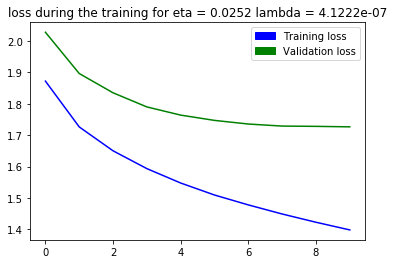

In [27]:
N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 4.1222e-07

dim_list = [d, 50, 30, K]
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]


n_batch= 100
eta= 0.0252
n_epochs= 10

rho = 0.9
W_init, b_init = initializeWb_He(dim_list)
eps = 10e-06
#print(compute_Cost_batch(X, Y, W_init, b_init, lamb,eps, None, None))
W, b, lostTrain, lostVal, mean_layer, std_layer = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init, eps, 0.9)

print("Accurency on the test = "  + str(compute_Accuracy_batch(X_test, y_test, W, b, eps, mean_layer, std_layer)))
plot_curve(lostTrain, lostVal)

## Grid Search

In [82]:
eta_start = 0.01
eta_end = 0.1
eta_number = 20
eta_step = (eta_end - eta_start) / eta_number
grid_eta = np.arange(eta_start, eta_end, eta_step)


lamb_start = 0.00001
lamb_end = 0.0001
lamb_number = 10
lamb_step = (lamb_end - lamb_start) / lamb_number
grid_lamb = np.arange(lamb_start, lamb_end, lamb_step)


N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 0.0001

dim_list = [d, 50, 30, K]
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]

n_batch= 100
n_epochs= 5
rho = 0.9

best_score = 0.0
best_lamb = 0
best_eta = 0
result = []
for lamb in tqdm(grid_lamb):
    for eta in tqdm(grid_eta):
        W_init, b_init = initializeWb_He(dim_list)
        W, b, lostTrain, lostVal = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init, eps, 0.99,None, None)
        acc = compute_Accuracy(X_val, y_val, W, b)
        result.append((acc,lamb,eta))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:03<01:12,  3.83s/it]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


 95%|█████████▌| 19/20 [01:21<00:04,  4.29s/it]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: inv

In [83]:
print(sorted(result)[-1])

(0.396, 1.9e-05, 0.064)


In [ ]:
N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 1.9e-05

dim_list = [d, 50, 30, K]
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]


n_batch= 100
eta= 0.064
n_epochs= 25
rho = 0.9
W_init, b_init = initializeWb_He(dim_list)
eps = 0.01
W, b, lostTrain, lostVal = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init, eps, 0.99,None, None)

print("Accurency on the test = "  + str(compute_Accuracy(X_test, y_test, W, b)))
plot_curve(lostTrain, lostVal)

Accurency on the test = 0.3842
